✅ Notes for this setup

- No feature scaling → XGBoost doesn’t need it.

- No need to drop multicollinear features → trees handle it naturally.

- Default hyperparameters already give strong performance.

Later you can:

- Tune max_depth, learning_rate, n_estimators.

- Use early_stopping_rounds with a validation set.

- Check feature importance with xgb.feature_importances_.

In [18]:
# ================================================
# 1. Imports
# ================================================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# ================================================
# 2. Load datasets (feature engineered, leakage-safe)
# ================================================
train_df = pd.read_csv("E:/ML-projects/Regression_ML_EndtoEnd/data/processed/feature_engineered_train.csv")
eval_df = pd.read_csv("E:/ML-projects/Regression_ML_EndtoEnd/data/processed/feature_engineered_eval.csv")

# ================================================
# 3. Define target & features
# ================================================
target = "price"

X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_eval = eval_df.drop(columns=[target])
y_eval = eval_df[target]

print("Train shape:", X_train.shape)
print("Eval shape:", X_eval.shape)


Train shape: (585199, 41)
Eval shape: (149423, 41)


In [ ]:
# Drop leftover categorical city columns (raw text or old encodings).
# The dataset already contains one-hot encoded city_norm_* features,
# so keeping these original columns causes dtype errors in XGBoost.
X_train = X_train.drop(columns=['city_norm', 'city_encoded', 'city'], errors='ignore')
X_eval  = X_eval.drop(columns=['city_norm', 'city_encoded', 'city'], errors='ignore')

In [ ]:
# Keep only numeric columns (int/float/bool) for XGBoost.
# Ensures no object/categorical columns remain that would break training.
X_train = X_train.select_dtypes(include=['int', 'float', 'bool'])
X_eval  = X_eval.select_dtypes(include=['int', 'float', 'bool'])

X_train = X_train.fillna(0)
X_eval  = X_eval.fillna(0)


In [23]:

# ================================================
# 4. Train a simple XGBoost Regressor
# ================================================
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# ================================================
# 5. Evaluate performance
# ================================================
y_pred = xgb_model.predict(X_eval)

mae = mean_absolute_error(y_eval, y_pred)
rmse = np.sqrt(mean_squared_error(y_eval, y_pred))
r2 = r2_score(y_eval, y_pred)

print("XGBoost Performance:")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")


XGBoost Performance:
MAE: 32,791.59
RMSE: 72,482.77
R²: 0.9593


In [24]:
X_train.columns

Index(['year', 'quarter', 'month', 'median_list_price', 'median_ppsf',
       'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list',
       'off_market_in_two_weeks', 'bank', 'bus', 'hospital', 'mall', 'park',
       'restaurant', 'school', 'station', 'supermarket', 'Total Population',
       'Median Age', 'Per Capita Income', 'Total Families Below Poverty',
       'Total Housing Units', 'Median Rent', 'Median Home Value',
       'Total Labor Force', 'Unemployed Population',
       'Total School Age Population', 'Total School Enrollment',
       'Median Commute Time', 'lat', 'lng', 'zipcode_freq_fresh',
       'zipcode_freq'],
      dtype='object')

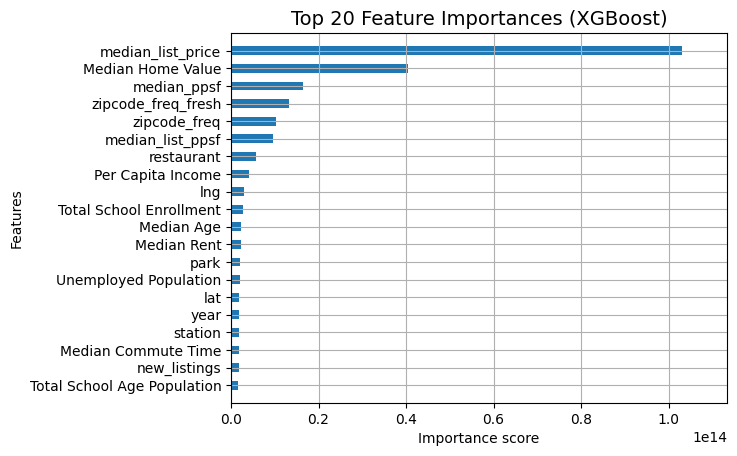

In [25]:
# Plot importances
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(
    xgb_model,
    importance_type="gain",
    max_num_features=20,
    height=0.5,
    show_values=False
)
plt.title("Top 20 Feature Importances (XGBoost)", fontsize=14)
plt.show()